In [20]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# # Data loading
data = pd.read_csv('dataset_images_dl_pro.csv')
data.columns = data.columns.str.strip()
data = data['Images;x;y;yaw'].str.split(';', expand=True)
data.columns = ['Images', 'x', 'y', 'yaw']

# Orientation value yaw is set to 0 or 1 (north or south)
def classify_yaw(yaw):
    yaw = float(yaw)
    if yaw >= 0 and yaw < 180:
        return 0  # north
    else:
        return 1  # south


In [9]:
data['yaw_class'] = data['yaw'].apply(classify_yaw)

# Normalization with MinMaxScaler 
scaler = MinMaxScaler()
data[['x', 'y']] = scaler.fit_transform(data[['x', 'y']].astype(float))


In [10]:
# updating the target values
targets = data[['x', 'y']].values.astype(float)
yaw_classes = data['yaw_class'].values
file_paths = data['Images'].values
xy_labels = data[['x', 'y']].values
yaw_labels = data['yaw_class'].values

In [11]:
# data loading and preprocessing 
def load_and_preprocess_image(file_path, labels):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = image / 255.0 
    return image, labels


In [12]:
# TensorFlow Dataset 
dataset = tf.data.Dataset.from_tensor_slices((file_paths, (xy_labels, yaw_labels)))
dataset = dataset.map(lambda x, y: load_and_preprocess_image(x, y), num_parallel_calls=tf.data.AUTOTUNE)

# splitting the data into training, testing and validation randomly 
dataset = dataset.shuffle(buffer_size=len(data), seed=42)
train_size = int(0.8 * len(data))
val_size = int(0.1 * len(data))
test_size = len(data) - train_size - val_size


In [13]:
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size).take(val_size)
test_dataset = dataset.skip(train_size + val_size)


In [14]:
# data augmentation applied 
def augment(image, labels):
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.3)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
    return image, labels

In [15]:
#data augmentation only applied to the training set
train_dataset = train_dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)

batch_size = 32
train_dataset = train_dataset.shuffle(1000).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)


In [18]:
# Custom CNN model
inputs = tf.keras.Input(shape=(224, 224, 3))
x = Conv2D(32, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(inputs)
x = MaxPooling2D((2, 2))(x)
x = BatchNormalization()(x)

x = Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = MaxPooling2D((2, 2))(x)
x = BatchNormalization()(x)

x = Conv2D(128, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = MaxPooling2D((2, 2))(x)
x = BatchNormalization()(x)

x = Conv2D(256, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = MaxPooling2D((2, 2))(x)
x = BatchNormalization()(x)

x = Flatten()(x)
x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = Dropout(0.5)(x)

output_xy = Dense(2, name='xy_output')(x)  # x and y output - regression
output_yaw = Dense(1, activation='sigmoid', name='yaw_output')(x)  # yaw output - classification 

model = tf.keras.Model(inputs=inputs, outputs=[output_xy, output_yaw])
model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 222, 222,  │        896 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 111, 111,  │          0 │ conv2d_8[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 111, 111,  │        128 │ max_pooling2d_8[… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 109, 109,  │     18,496 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 54, 54,    │          0 │ conv2d_9[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 54, 54,    │        256 │ max_pooling2d_9[… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 52, 52,    │     73,856 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 26, 26,    │          0 │ conv2d_10[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 26, 26,    │        512 │ max_pooling2d_10… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 24, 24,    │    295,168 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 12, 12,    │          0 │ conv2d_11[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 12, 12,    │      1,024 │ max_pooling2d_11… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 36864)     │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │  4,718,720 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ xy_output (Dense)   │ (None, 2)         │        258 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ yaw_output (Dense)  │ (None, 1)         │        129 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 5,109,443 (19.49 MB)

 Trainable params: 5,108,483 (19.49 MB)

 Non-trainable params: 960 (3.75 KB)

In [22]:
# Model compile with Adam optimizer and mse and binary crossentropy
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss={'xy_output': 'mse', 'yaw_output': 'binary_crossentropy'},
              metrics={'xy_output': 'mse', 'yaw_output': 'accuracy'})

# Early stopping to overcome the overfitting and model checkpoint to save the model
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_classification_yaw_customcnn.keras', monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)


In [23]:

history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=250,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr])


Epoch 1/250


2024-05-21 17:04:58.231197: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


484/484 ━━━━━━━━━━━━━━━━━━━━ 58s 89ms/step - loss: 7.1585 - xy_output_mse: 1.0505 - yaw_output_accuracy: 0.7217 - val_loss: 5.5969 - val_xy_output_mse: 0.0777 - val_yaw_output_accuracy: 0.9555 - learning_rate: 1.0000e-04
Epoch 2/250
484/484 ━━━━━━━━━━━━━━━━━━━━ 47s 88ms/step - loss: 5.5171 - xy_output_mse: 0.1880 - yaw_output_accuracy: 0.9240 - val_loss: 4.7326 - val_xy_output_mse: 0.0580 - val_yaw_output_accuracy: 0.9928 - learning_rate: 1.0000e-04
Epoch 3/250
484/484 ━━━━━━━━━━━━━━━━━━━━ 48s 89ms/step - loss: 4.7094 - xy_output_mse: 0.1427 - yaw_output_accuracy: 0.9518 - val_loss: 3.9417 - val_xy_output_mse: 0.0429 - val_yaw_output_accuracy: 0.9907 - learning_rate: 1.0000e-04
Epoch 4/250
484/484 ━━━━━━━━━━━━━━━━━━━━ 47s 88ms/step - loss: 3.8623 - xy_output_mse: 0.1064 - yaw_output_accuracy: 0.9678 - val_loss: 3.1385 - val_xy_output_mse: 0.0327 - val_yaw_output_accuracy: 0.9979 - learning_rate: 1.0000e-04
Epoch 5/250
484/484 ━━━━━━━━━━━━━━━━━━━━ 46s 86ms/step - loss: 3.0527 - xy_outpu

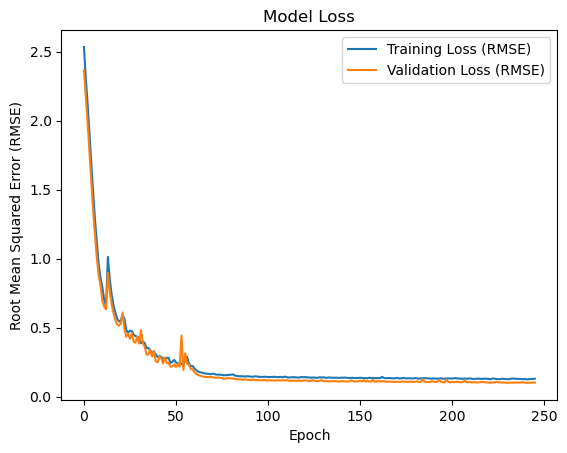

In [24]:
# Training and validation loss graph with RMSE 
plt.plot(np.sqrt(history.history['loss']), label='Training Loss (RMSE)')
plt.plot(np.sqrt(history.history['val_loss']), label='Validation Loss (RMSE)')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.legend(loc='upper right')
plt.show()



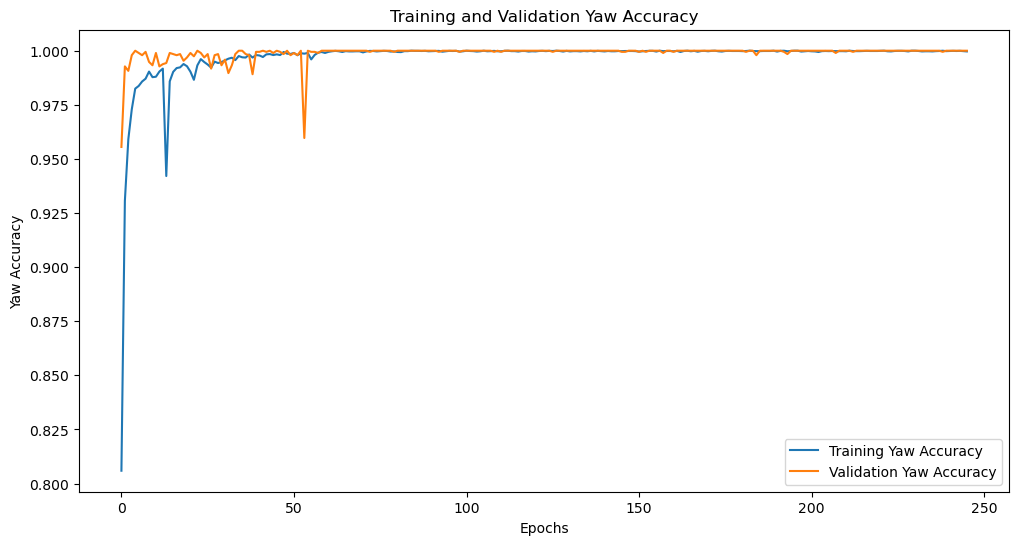

In [27]:
# yaw accuracy over epochs
plt.figure(figsize=(12, 6))
plt.plot(history.history['yaw_output_accuracy'], label='Training Yaw Accuracy')
plt.plot(history.history['val_yaw_output_accuracy'], label='Validation Yaw Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Yaw Accuracy')
plt.title('Training and Validation Yaw Accuracy')
plt.legend()
plt.show()

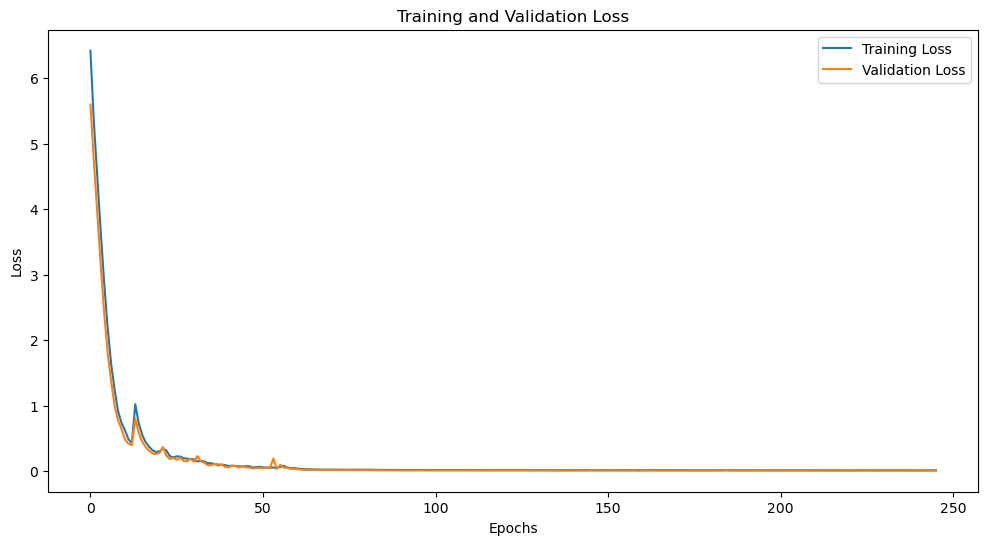

In [28]:
# Training and validation loss graph
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [25]:
# testing results on test set 
test_results = model.evaluate(test_dataset)
print(f"Test loss: {test_results[0]}")
print(f"Test XY MSE: {test_results[1]}")
print(f"Test Yaw Accuracy: {test_results[2]}")

61/61 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 0.0100 - xy_output_mse: 6.6966e-04 - yaw_output_accuracy: 1.0000
Test loss: 0.010027534328401089
Test XY MSE: 0.0006919315201230347
Test Yaw Accuracy: 1.0


2024-05-21 20:18:35.159199: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


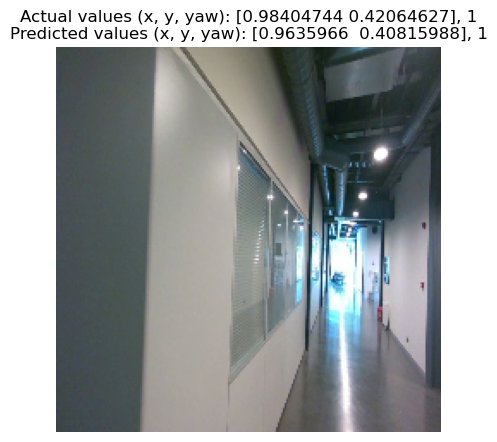

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


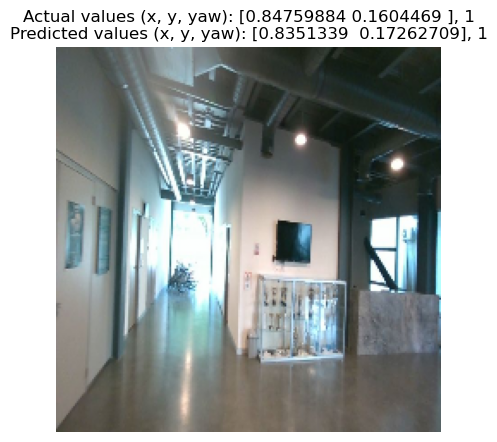

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


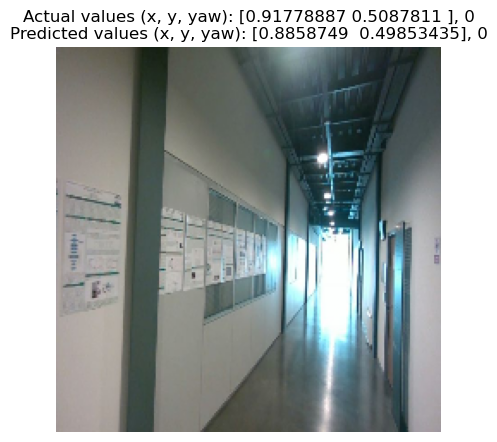

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


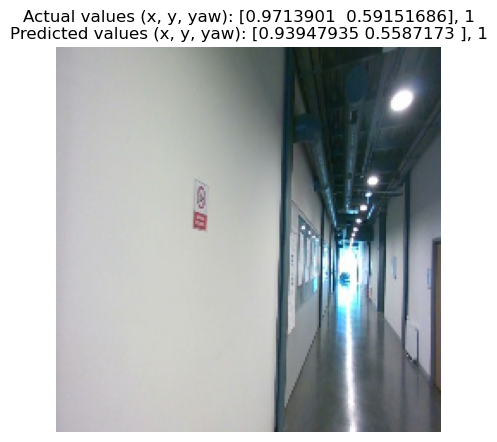

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


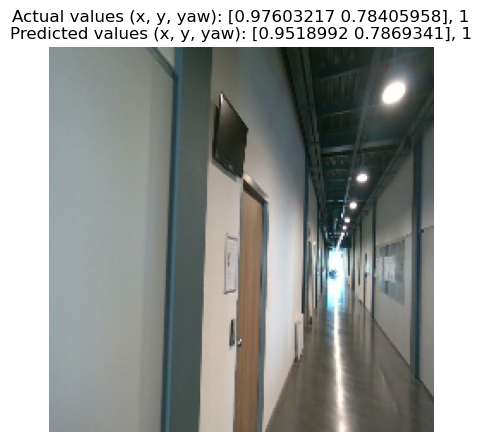

In [26]:
import random

test_examples = list(test_dataset.unbatch().as_numpy_iterator())

# random prediction from the test data 
def plot_random_prediction(test_examples, model):
    random_example = random.choice(test_examples)

    image, (true_xy, true_yaw) = random_example
    image = tf.expand_dims(image, axis=0)  
    prediction = model.predict(image)
    pred_xy = prediction[0][0]
    pred_yaw = prediction[1][0]
    
    pred_yaw = 1 if pred_yaw > 0.5 else 0

    plt.figure(figsize=(5, 5))
    plt.imshow(image[0])
    plt.title(f"Actual values (x, y, yaw): {true_xy}, {true_yaw}\n"
              f"Predicted values (x, y, yaw): {pred_xy}, {pred_yaw}")
    plt.axis('off')
    plt.show()

for _ in range(5):
    plot_random_prediction(test_examples, model)
